In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler

In [2]:
cfg = None
with open('config.yaml', 'r') as config:
    cfg = yaml.safe_load(config)["Lab_5"]

In [3]:
data = pd.read_excel(cfg["Doctor"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       58 non-null     int64  
 1   x1      58 non-null     int64  
 2   x2      58 non-null     float64
 3   x3      58 non-null     float64
 4   x4      58 non-null     int64  
 5   x5      58 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 2.8 KB


In [23]:
data.head(10)

,y,x1,x2,x3,x4,x5
0,0,14,4.30,1.00,2,3.72
1,0,12,11.54,8.49,3,40.28
2,0,14,5.84,2.47,3,56.00
3,1,11,14.70,6.60,1,57.41
4,0,21,5.10,3.48,1,83.00
5,0,12,6.14,3.09,1,62.57
6,1,17,5.05,1.14,3,22.16
7,1,12,11.30,8.85,1,12.00
8,0,14,3.30,1.20,3,110.00
9,1,19,6.60,4.30,1,2.96


In [24]:
data.describe()

,y,x1,x2,x3,x4,x5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.637931,16.327586,10.327931,7.141379,2.344828,45.135000
std,0.484796,3.213939,3.957742,3.749343,0.928151,53.956171
min,0.000000,11.000000,3.300000,1.000000,1.000000,0.800000
25%,0.000000,14.000000,6.375000,3.985000,1.000000,22.115000
50%,1.000000,16.000000,10.450000,6.835000,3.000000,38.935000
75%,1.000000,19.000000,13.400000,9.975000,3.000000,53.125000
max,1.000000,27.000000,19.000000,16.000000,3.000000,399.800000


### Анализ данных и построение моделей

In [5]:
df = data.copy(deep=True)

df["y"] = pd.Categorical(df["y"])

In [26]:
df.describe(include=["category"])

,y
count,58
unique,2
top,1
freq,37


In [6]:
X = df.drop(columns=['y'], axis=1)
y = df['y']

In [7]:
X = sm.add_constant(X)

# Training the logistic regression model on the training data
model = sm.Logit(y, X).fit()

y_pred = model.predict(X)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]  # Converting probabilities to binary classes

# Evaluating the model's performance
accuracy = accuracy_score(y, y_pred_binary)

print(f"Model accuracy: {accuracy}")
coeff = round(model.params, 3)
coeff

Optimization terminated successfully.
         Current function value: 0.341788
         Iterations 8
Model accuracy: 0.896551724137931


const   -10.942
x1        0.455
x2        0.809
x3       -0.356
x4        0.126
x5       -0.032
dtype: float64

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.4779
Time:                        00:02:24   Log-Likelihood:                -19.824
converged:                       True   LL-Null:                       -37.967
Covariance Type:            nonrobust   LLR p-value:                 8.325e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9423      3.871     -2.827      0.005     -18.529      -3.356
x1             0.4555      0.180      2.529      0.011       0.102       0.809
x2             0.8085      0.436      1.855      0.064      -0.046       1.663
x3            -0.3559      0.418     -0.852      0.394      -1.175       0.463
x4             0.1262      0.422      0.299      0.765      -0.701       0.954
x5            -0.0319      0.020     -1.605      0.109      -0.071       0.007
==============================================================================
"""

$$
logit(p)= -10.942 + 0.455x_1 + 0.809x_2 - 0.356x_3 + 0.126x_4 - 0.032x_5
$$

In [30]:
p_values = model.pvalues
print("Значения p для каждого коэффициента:")
print(p_values)

Значения p для каждого коэффициента:
const    0.024391
x1       0.011451
x2       0.063629
x3       0.394305
x4       0.765029
x5       0.108591
dtype: float64


In [31]:
model.wald_test_terms(scalar=True)

<class 'statsmodels.stats.contrast.WaldTestResults'>
           chi2    P>chi2  df constraint
const  5.066606  0.024391              1
x1     6.393987  0.011451              1
x2     3.440181  0.063629              1
x3     0.725626  0.394305              1
x4     0.089331  0.765029              1
x5     2.574608  0.108591              1

In [32]:
wald_stat = model.wald_test("(x1=0, x2=0, x3=0, x4=0, x5=0)", scalar=True)
wald_stat

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=13.100892445653392, p-value=0.022451419971989618, df_denom=5>

Если рассмотреть значения p-value, то можно сделать вывод, что значимыми являются только свободный член и $x_1$. Также по тесту Вальда можно сделать вывод, что модель значима в целом т.к p-value < 0.05. Стоит заметить, что в данном случае нельзя опираться на этот тест, ибо он применим к большим выборкам

In [33]:
lr_stat = model.llr
lr_pvalue = model.llr_pvalue
print("Likelihood Ratio Test for overall model significance:")
print(f"Statistic: {round(lr_stat, 5)}, p-value: {round(lr_pvalue, 8)}")

Likelihood Ratio Test for overall model significance:
Statistic: 36.28609, p-value: 8.3e-07


p-value < 0.05 => модель значима в целом

In [34]:
conf_intervals = model.conf_int()
conf_intervals.columns = ["[0.025", "0.975]"]
conf_intervals

,[0.025,0.975]
const,0.150116,2.172625
x1,0.326358,2.575997
x2,-0.179907,6.524272
x3,-4.366293,1.720750
x4,-0.645323,0.877554
x5,-3.785165,0.377405


Также значимыми коэффициентами являются только свободный член и $x_1$

**Замечание:** стоит отметить что для обоих моделей, если удалить $x_2$, точность падает довольно сильно

In [35]:
X_train = X
X_train = sm.add_constant(X_train)
modelLogit = sm.Logit(y, X_train).fit()
modelProbit = sm.Probit(y, X_train).fit()

y_logit_pred = modelLogit.predict(X_train)
y_logit_pred_binary = [1 if x > 0.5 else 0 for x in y_logit_pred] 

y_probit_pred = modelProbit.predict(X_train)
y_probit_pred_binary = [1 if x > 0.5 else 0 for x in y_probit_pred] 

accuracyLogit = accuracy_score(y, y_logit_pred_binary)
accuracyProbit = accuracy_score(y, y_probit_pred_binary)
round(accuracyLogit, 5), round(accuracyProbit, 5)

Optimization terminated successfully.
         Current function value: 0.341788
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342187
         Iterations 7


(0.89655, 0.87931)

In [36]:
X_train = X.copy().drop(columns=["x2", "x3", "x4", "x5"])
X_train = sm.add_constant(X_train)
modelLogit = sm.Logit(y, X_train).fit()
modelProbit = sm.Probit(y, X_train).fit()

y_logit_pred = modelLogit.predict(X_train)
y_logit_pred_binary = [1 if x > 0.5 else 0 for x in y_logit_pred] 

y_probit_pred = modelProbit.predict(X_train)
y_probit_pred_binary = [1 if x > 0.5 else 0 for x in y_probit_pred] 

accuracyLogit = accuracy_score(y, y_logit_pred_binary)
accuracyProbit = accuracy_score(y, y_probit_pred_binary)
round(accuracyLogit, 5), round(accuracyProbit, 5)

Optimization terminated successfully.
         Current function value: 0.600556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601092
         Iterations 5


(0.65517, 0.65517)

In [37]:
X_train = X.copy().drop(columns=["x3", "x4", "x5"])
X_train = sm.add_constant(X_train)
modelLogit = sm.Logit(y, X_train).fit()
modelProbit = sm.Probit(y, X_train).fit()

y_logit_pred = modelLogit.predict(X_train)
y_logit_pred_binary = [1 if x > 0.5 else 0 for x in y_logit_pred] 

y_probit_pred = modelProbit.predict(X_train)
y_probit_pred_binary = [1 if x > 0.5 else 0 for x in y_probit_pred] 

accuracyLogit = accuracy_score(y, y_logit_pred_binary)
accuracyProbit = accuracy_score(y, y_probit_pred_binary)
round(accuracyLogit, 5), round(accuracyProbit, 5)

Optimization terminated successfully.
         Current function value: 0.415948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419247
         Iterations 6


(0.86207, 0.86207)

In [38]:
modelProbit.aic, modelLogit.aic

(np.float64(54.63263586083632), np.float64(54.24995008092664))

aic у обоих моделей почти одинаков => нет особой разницы в их использовании

In [39]:
confusion_matrix(y, y_logit_pred_binary)

array([[17,  4],
       [ 4, 33]])

In [40]:
confusion_matrix(y, y_probit_pred_binary)

array([[17,  4],
       [ 4, 33]])

Можно сделать вывод, что модель ошибкается не очень часто

In [41]:
def sensitivity(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    TP = cm[1, 1]
    FN = cm[1, 0]
    return TP / (TP + FN)

# Function to calculate specificity
def specificity(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP)

sensivity_logit = sensitivity(y, y_logit_pred_binary)
specificity_logit = specificity(y, y_logit_pred_binary)

sensivity_probit = sensitivity(y, y_probit_pred_binary)
specificity_probit = specificity(y, y_probit_pred_binary)

result = pd.DataFrame(
    {
        'sensitivity': [sensivity_logit, sensivity_probit],
        'specificity': [specificity_logit, specificity_probit]
    },
    index=['logit', 'probit']
)

result

,sensitivity,specificity
logit,0.891892,0.809524
probit,0.891892,0.809524


При попытке подбора самостоятельного подбора p, выяснилось, что наилучшее значение accurancy, AUC достигается при 0.5. Из этого можно сделать вывод, что оно уже являестя достаточно хорошим. Это подтвержают и графики ниже

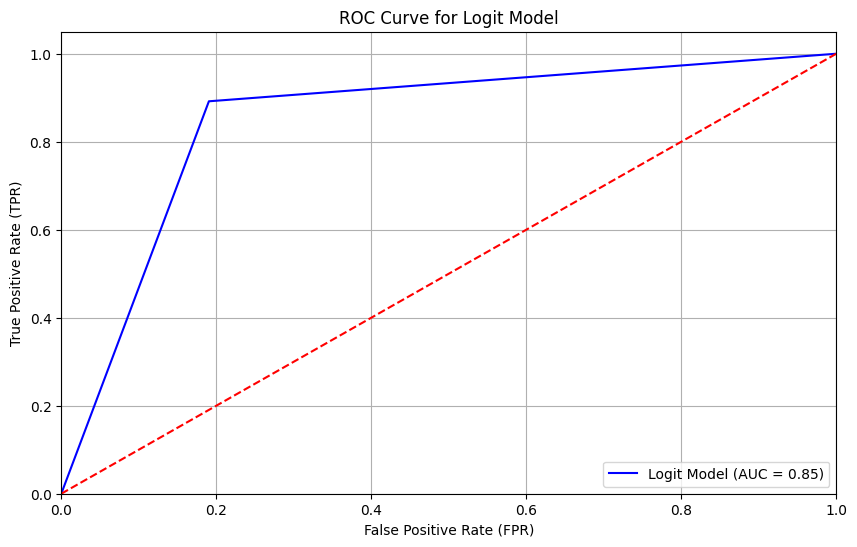

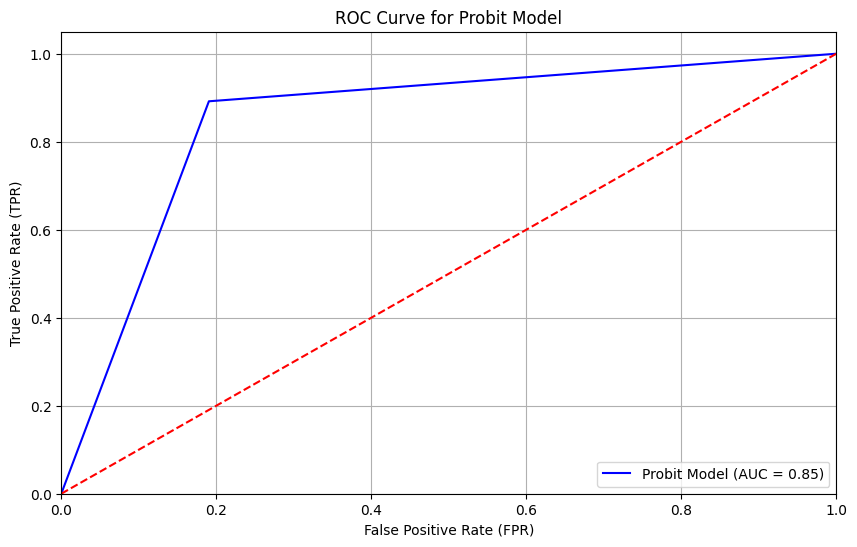

In [42]:

def plotROC(y_true, y_scores, model_name):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plotROC(y, y_logit_pred_binary, 'Logit Model')

plotROC(y, y_logit_pred_binary, 'Probit Model')

In [43]:
def stepwise_selection_with_aic(X, y, initial_features):
    included = list(initial_features)
    best_aic = float('inf')

    while True:
        changed = False

        # Evaluating the current model
        X_with_const = sm.add_constant(X[included])
        model = sm.OLS(y, X_with_const).fit()
        current_aic = model.aic

        # Check for removal of features
        for feature in included:
            X_temp = X_with_const.drop(columns=feature)
            model_temp = sm.OLS(y, X_temp).fit()
            if model_temp.aic < current_aic:
                included.remove(feature)
                current_aic = model_temp.aic
                changed = True
                print(f"Removed {feature} with AIC {model_temp.aic:.4f}")
                break

        # Check for addition of features
        for feature in X.columns:
            if feature not in included:
                X_temp = X_with_const.copy()
                X_temp[feature] = X[feature]
                model_temp = sm.OLS(y, X_temp).fit()
                if model_temp.aic < current_aic:
                    included.append(feature)
                    changed = True
                    print(f"Added {feature} with AIC {model_temp.aic:.4f}")
                    break

        if not changed:
            break

    return included

In [44]:
# Initializing initial features (all features)
initial_features = X.columns.tolist()
selected_features = stepwise_selection_with_aic(X, y, initial_features)
X_clear = sm.add_constant(X[selected_features])

Removed x3 with AIC 52.4587
Removed x4 with AIC 50.7155


In [45]:
X_train = X_clear
X_train = sm.add_constant(X_train)
modelLogit = sm.Logit(y, X_train).fit()
modelProbit = sm.Probit(y, X_train).fit()

y_logit_pred = modelLogit.predict(X_train)
y_logit_pred_binary = [1 if x > 0.5 else 0 for x in y_logit_pred] 

y_probit_pred = modelProbit.predict(X_train)
y_probit_pred_binary = [1 if x > 0.5 else 0 for x in y_probit_pred] 

accuracyLogit = accuracy_score(y, y_logit_pred_binary)
accuracyProbit = accuracy_score(y, y_probit_pred_binary)
round(accuracyLogit, 5), round(accuracyProbit, 5)

Optimization terminated successfully.
         Current function value: 0.350155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351629
         Iterations 7


(0.86207, 0.87931)

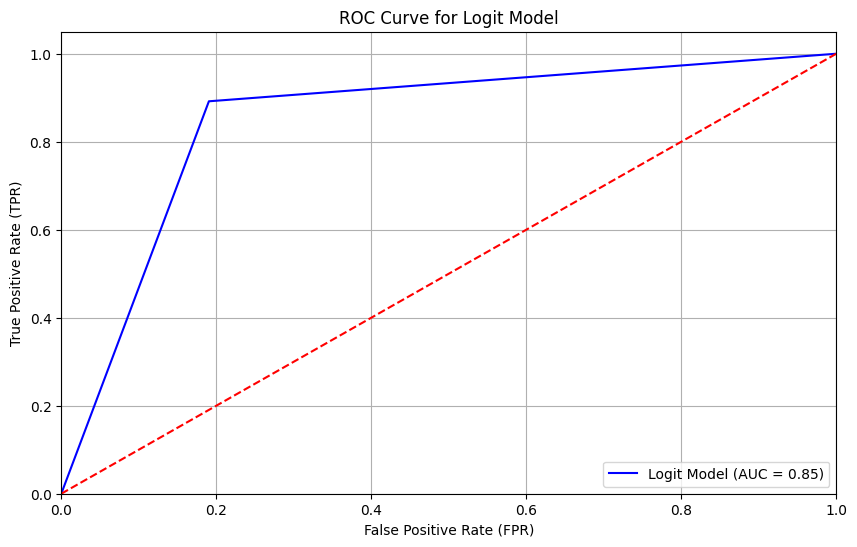

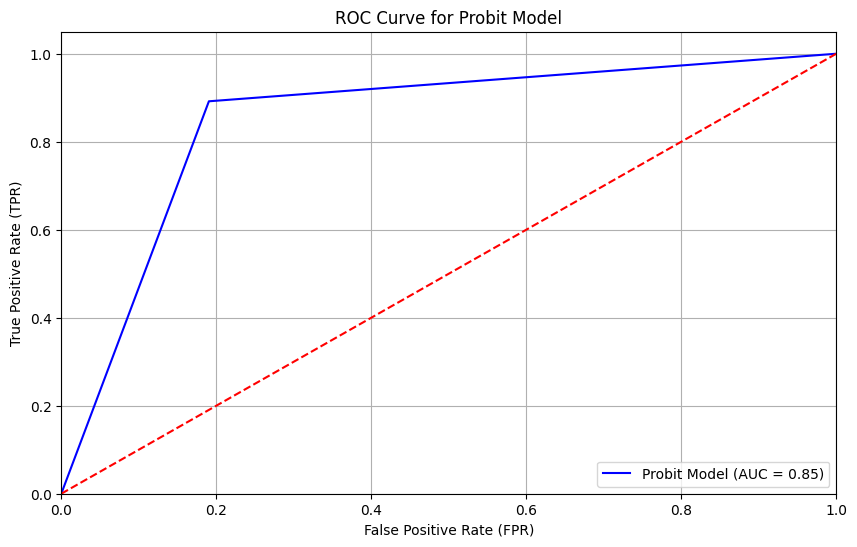

In [46]:
plotROC(y, y_logit_pred_binary, 'Logit Model')

plotROC(y, y_logit_pred_binary, 'Probit Model')

Если оставить x5 результаты практически не изменятся